## Building blocks
We have defined blocks as custom Qiskit gates and combined them in a single Layer class.

In [1]:
from blocks import EvenBlock, OddBlock
from layer import Layer

from qiskit.circuit import ParameterVector

Even Block


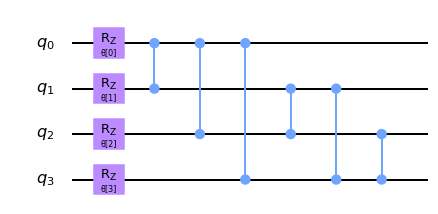

In [2]:
theta = ParameterVector('θ', 4)

print('Even Block')
EvenBlock(4, theta).definition.draw('mpl')

Odd Block


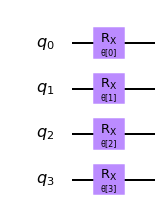

In [3]:
print('Odd Block')
OddBlock(4, theta).definition.draw('mpl')

Layer


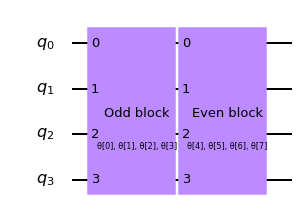

In [4]:
theta = ParameterVector('θ', 8)

print('Layer')
Layer(4, theta).definition.draw('mpl')

## Cost function 
$$ \epsilon = \text{min}_{\theta} \Big|\Big|  |\psi(\theta) \rangle - |\phi \rangle \Big|\Big|_{l_2}^2 = 2 \cdot \big(1 - \text{Re}(\langle \psi(\theta) | \phi \rangle)\big)$$

In [5]:
import numpy as np
from qiskit import Aer, execute

backend = Aer.get_backend('statevector_simulator')

def cost(qc, params, target, values):
    
    # circuit
    circ = qc.bind_parameters(dict(zip(params, values)))
    
    # simulate
    result = execute(circ, backend).result()
    state = result.get_statevector()
    
    cost = 1 - np.dot(target, state).real
    
    return cost

## Optimization 

We optimize the parameters of variatonal circuits with increasing number of layers (up to 4) to match the output state with a randomly generated target qubit state. 

We repeat the optimization process four times to gather more accurate statistics.

In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import random_statevector
from scipy.optimize import minimize

nqubits = 4

# number of experiments
nexp = 4

# randomly generated target qubit state
target = [random_statevector(pow(2, nqubits)).data for _ in range(nexp)]


qc = QuantumCircuit(nqubits)

# maximum number of layers
L = 4

# error distance
epsilon = np.zeros((L, nexp))
# no. of function evaluations made from the optimizer
nfev = np.zeros((L, nexp))

for i in range(L):
    print('\nNumber of Layers: ', i + 1)
    
    # add another layer
    params = ParameterVector(name='θ{}'.format(i), 
                             length=2 * nqubits)
    
    qc.append(Layer(nqubits, params), 
              range(nqubits))
    
    params = qc.parameters
    
    # run multiple times for each circuit
    for j in range(nexp):
        # random initial choice for the angles
        values = np.random.uniform(0, 2 * np.pi, len(params))

        # minimize cost function
        cost_fn = lambda theta: cost(qc, params, target[j], theta)

        res = minimize(cost_fn, values)

        # store result
        epsilon[i, j] = res.fun
        nfev[i, j] = res.nfev
    
    print('      fun: ', np.mean(epsilon[i]))
    print('     nfev: ', np.mean(nfev[i]))


Number of Layers:  1
      fun:  0.3410005856935111
     nfev:  436.5

Number of Layers:  2
      fun:  0.11731090774334962
     nfev:  1194.25

Number of Layers:  3
      fun:  0.011198963489102487
     nfev:  3481.25

Number of Layers:  4
      fun:  2.124659892188685e-07
     nfev:  5469.75


## Visualization
The error drops quickly down to zero as the number of layers in the circuit increases since with a larger set of parameters we can represent more states in the Hilbert space. 

As it's expected, the computational cost, measured with function evaluations during optimization, increases too. 

However, we should notice that in a real quantum computer more layers means more noise and we should keep in mind this trade-off.

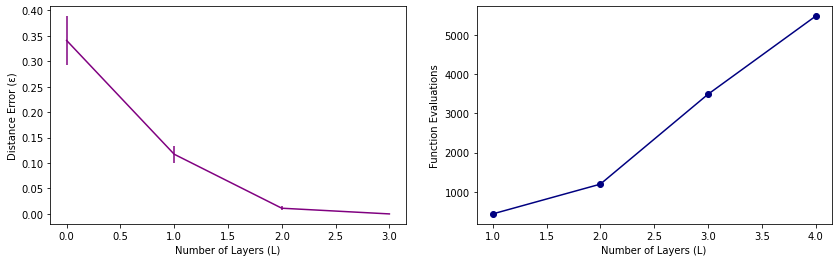

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))

# error
scale = 1
epsilon = scale * epsilon


err = (np.max(epsilon, axis=1) - np.min(epsilon, axis=1)) / 2
# err = np.var(epsilon, axis=1)

plt.subplot(121)
plt.errorbar(np.arange(L), np.mean(epsilon, axis=1), yerr=err, 
             color='purple')


plt.xlabel('Number of Layers (L)')
plt.ylabel('Distance Error (ε)');


# fun. eval
plt.subplot(122)
plt.plot(np.arange(1, L+1), np.mean(nfev, axis=1), 
         color='navy', )
plt.scatter(np.arange(1, L+1), np.mean(nfev, axis=1), 
         color='navy')

plt.xlabel('Number of Layers (L)')
plt.ylabel('Function Evaluations');